In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# F&B Revenue Forecast Model

## Data

In [41]:
#import raw revenue data
df_2016 = pd.read_csv("../../raw_data/orders2016.csv", sep=";")
df_2017 = pd.read_csv("../../raw_data/orders2017.csv", sep=";")
df_2018 = pd.read_csv("../../raw_data/orders2018.csv", sep=";")
df_2019 = pd.read_csv("../../raw_data/orders2019.csv", sep=";")
df_2020 = pd.read_csv("../../raw_data/orders2020.csv", sep=";")
df_2021 = pd.read_csv("../../raw_data/orders2021.csv", sep=";")
df_2022 = pd.read_csv("../../raw_data/orders2022.csv", sep=";")

df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

#Dropping unnecessary columns, grouping by "date", summing "item_price" to get daily revenues

for i, df in enumerate(df_list):
    df_list[i] = pd.DataFrame(df.groupby(by="date")["item_price"].sum()/100)

#Concat all data in one dataframe, rename the columns for prophet

df = pd.concat(df_list, ignore_index=False)
df = df.rename(columns={"date": "ds", "item_price": "y"})
df["ds"] = df.index
df = df.reset_index(drop=True)
df = df[["ds","y"]]
df

#turning the ds (date) column into datetime

df['ds']=pd.to_datetime(df['ds'])

#Dropping outliers
df = df[df["y"]>=60]
df = df[df["y"]<=2300]
df = df.reset_index(drop=True)

In [42]:
#Loading additional regressor
feature_df = pd.read_csv("../../feature_data/final_feature_selection.csv")
feature_df["ds"] = pd.to_datetime(feature_df['ds'])

In [43]:
#Loading weather prediction data
weather_forecast = pd.read_csv("../../feature_data/finall_pred_weather.csv")
weather_forecast["ds"] = pd.to_datetime(weather_forecast["ds"])
weather_forecast["forecast dt iso"] = pd.to_datetime(weather_forecast["forecast dt iso"])

In [44]:
merged_df = pd.merge(df,feature_df,how="left")

In [45]:
merged_df['cap'] = 1.2 * df['y'].max()

In [46]:
#Setting variables
horizon = 16

#Splitting the data
split_date = "2022-10-14"
index_split = df[df["ds"]==split_date].index[0]
df_train = merged_df.iloc[:index_split]
df_test = merged_df.iloc[index_split:]
y_test = pd.DataFrame(df_test["y"])
weather_index_split = weather_forecast[weather_forecast["forecast dt iso"]==split_date].index[0]
weather_predict = weather_forecast.iloc[weather_index_split:weather_index_split+horizon,:]
weather_predict = weather_predict.drop(columns="forecast dt iso")

## Model

### Fitting

In [47]:
from prophet import Prophet

#Instantiate
m = Prophet(growth = 'logistic', changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.1, seasonality_mode='multiplicative',\
           yearly_seasonality= 12, weekly_seasonality = True)

#Adding regressors/features
m.add_regressor("temp", prior_scale=0.5, mode="additive")
#m.add_regressor("humidity", prior_scale=0.5, mode="additive")
m.add_regressor("wind_speed", prior_scale=0.5, mode="additive")
m.add_regressor("wind_deg", prior_scale=0.5, mode="additive")
m.add_regressor("rain", prior_scale=0.5, mode="additive")
m.add_regressor("clouds", prior_scale=0.5, mode="additive")
m.add_regressor("Holiday", prior_scale=0.5, mode="multiplicative")
m.add_regressor("inflation_rate", prior_scale=0.5, mode="multiplicative")
#m.add_regressor("Consumption Climate", prior_scale=0.5, mode="multiplicative")
#m.add_regressor("cov_lock", prior_scale=0.5, mode="multiplicative")
#m.add_regressor("unemp_Berlin_Mitte", prior_scale=0.5, mode="multiplicative")

#Fitting the model
m = m.fit(df_train)

16:37:54 - cmdstanpy - INFO - Chain [1] start processing
16:37:55 - cmdstanpy - INFO - Chain [1] done processing


### Crossvalidating

In [48]:
#Crossvalidating the model
from prophet.diagnostics  import cross_validation

df_cv = cross_validation(m, initial='720 days', horizon = '16 days', period = '16 days')


  0%|          | 0/72 [00:00<?, ?it/s]

16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing
16:38:01 - cmdstanpy - INFO - Chain [1] start processing
16:38:01 - cmdstanpy - INFO - Chain [1] done processing
16:38:02 - cmdstanpy - INFO - Chain [1] start processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
16:38:02 - cmdstanpy - INFO - Chain [1] start processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
16:38:03 - cmdstanpy - INFO - Chain [1] start processing
16:38:03 - cmdstanpy - INFO - Chain [1] done processing
16:38:03 - cmdstanpy - INFO - Chain [1] start processing
16:38:03 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
16:38:05 - cmdstanpy - INFO - Chain [1] start processing
16:38:05 - cmdstanpy - INFO - Chain [1]

In [49]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,43232.264937,207.923700,164.716856,0.356191,0.228486,0.292625,0.835821
1,3 days,40900.335452,202.238314,159.786967,0.337227,0.226127,0.274338,0.865119
2,4 days,48883.760814,221.096723,162.879345,0.368735,0.213856,0.298140,0.843137
3,5 days,48645.279302,220.556748,164.807620,0.415104,0.204449,0.322744,0.844276
4,6 days,46869.375478,216.493361,172.098054,0.419668,0.236635,0.354762,0.819088
5,7 days,48366.847426,219.924640,176.935611,0.366866,0.274096,0.335653,0.821895
6,8 days,49125.775579,221.643352,176.401736,0.403180,0.238248,0.330284,0.813453
7,9 days,59318.808958,243.554530,185.975688,0.422988,0.239992,0.349208,0.772222
8,10 days,62165.431857,249.329966,190.898825,0.435433,0.252244,0.347158,0.803439
9,11 days,53947.991255,232.267069,177.199330,0.445597,0.211147,0.318692,0.851587


In [50]:
#Average MAE
average_mae_baseline = df_p["mae"].mean()
average_mae_baseline

176.36010811224818

### Analyzing seasonal trend

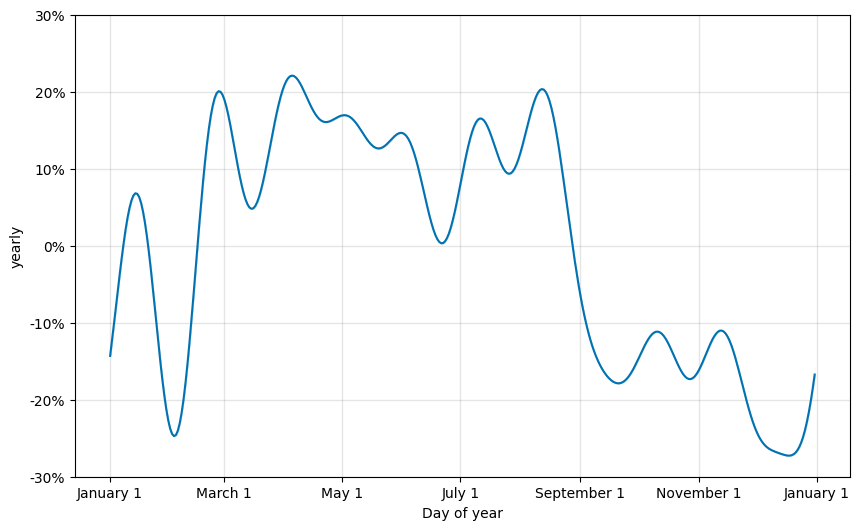

In [34]:
from prophet.plot import plot_yearly

a = plot_yearly(m)

### Predicting

In [51]:
#Creating future dataframe
future = m.make_future_dataframe(periods=horizon)
future['cap'] = 1.2 * merged_df['y'].max()

In [52]:
#Adding feature values to future dataframe
future = pd.merge(future,feature_df,how="left")
future

,ds,cap,y,temp,humidity,wind_speed,wind_deg,rain,clouds,Holiday,inflation_rate,Consumption Climate,cov_lock,unemp_Berlin_Mitte
0,2016-09-01,2690.76,365.9,25.90,35,6.70,270,0.00,0,1,0.5,10.0,0,0.095
1,2016-09-02,2690.76,358.6,22.18,46,4.63,280,0.00,75,1,0.5,10.0,0,0.095
2,2016-09-03,2690.76,487.5,24.94,41,6.70,270,0.00,40,0,0.5,10.0,0,0.095
3,2016-09-04,2690.76,90.9,19.94,73,6.70,230,0.00,75,0,0.5,10.0,0,0.095
4,2016-09-05,2690.76,125.0,19.94,73,4.63,320,0.21,40,0,0.5,10.0,0,0.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,2022-10-25,2690.76,292.7,16.67,74,5.66,260,0.00,75,1,8.4,-41.9,0,0.090
1677,2022-10-26,2690.76,346.6,16.98,73,3.09,150,0.00,0,1,8.4,-41.9,0,0.090
1678,2022-10-27,2690.76,414.5,19.57,73,4.63,200,0.00,0,1,8.4,-41.9,0,0.090
1679,2022-10-28,2690.76,620.0,21.83,68,4.12,190,0.00,0,1,8.4,-41.9,0,0.090


In [53]:
#Update Future Timeframe with prediction weather data instead of historical weather data to prevent overfitting
cols_to_update = ['temp', 'humidity', 'clouds', 'wind_speed', 'wind_deg', 'rain']
future.loc[future.index[-(horizon):], cols_to_update] = weather_predict[cols_to_update].values

In [38]:
future

,ds,cap,y,temp,humidity,wind_speed,wind_deg,rain,clouds,Holiday,inflation_rate,Consumption Climate,cov_lock,unemp_Berlin_Mitte
0,2016-09-01,2690.76,365.9,25.90,35.0,6.70,270.0,0.00,0.0,1,0.5,10.0,0,0.095
1,2016-09-02,2690.76,358.6,22.18,46.0,4.63,280.0,0.00,75.0,1,0.5,10.0,0,0.095
2,2016-09-03,2690.76,487.5,24.94,41.0,6.70,270.0,0.00,40.0,0,0.5,10.0,0,0.095
3,2016-09-04,2690.76,90.9,19.94,73.0,6.70,230.0,0.00,75.0,0,0.5,10.0,0,0.095
4,2016-09-05,2690.76,125.0,19.94,73.0,4.63,320.0,0.21,40.0,0,0.5,10.0,0,0.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2022-04-10,2690.76,483.6,11.84,72.0,4.25,255.0,0.02,91.0,1,8.4,-26.6,0,0.090
1480,2022-04-11,2690.76,574.4,10.73,66.0,3.66,279.0,0.00,99.0,1,8.4,-26.6,0,0.090
1481,2022-04-12,2690.76,748.1,8.41,82.0,2.14,148.0,5.92,95.0,1,8.4,-26.6,0,0.090
1482,2022-04-13,2690.76,919.3,9.00,68.0,2.50,275.0,0.00,61.0,1,8.4,-26.6,0,0.090


In [59]:
#Predicting
forecast = m.predict(future)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=200.0)
seven_day_forecast = forecast.tail(horizon)
seven_day_forecast_slim = seven_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
prediction_forecast = seven_day_forecast_slim
prediction_forecast["y_true"] = y_test.head(horizon)
prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
prediction_forecast["mae_rolling"] = abs(prediction_forecast["error"]).rolling(window=len(prediction_forecast), min_periods=1).mean()
prediction_forecast

/tmp/ipykernel_8047/2919749544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_8047/2919749544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_8047/2919749544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,ds,yhat_lower,yhat,yhat_upper,y_true,error,mae_rolling
1665,2022-10-14,200.000000,340.514875,602.308102,286.5,54.014875,54.014875
1666,2022-10-15,217.743688,482.149228,770.900860,871.7,-389.550772,221.782824
1667,2022-10-16,200.000000,339.468321,616.654225,140.9,198.568321,214.044656
1668,2022-10-17,200.000000,311.392705,570.965773,632.8,-321.407295,240.885316
1669,2022-10-18,200.000000,200.000000,238.413244,226.9,-26.900000,198.088253
1670,2022-10-19,200.000000,253.115417,528.869448,217.7,35.415417,170.976113
1671,2022-10-20,200.000000,216.593450,494.125606,260.2,-43.606550,152.780462
1672,2022-10-21,200.000000,237.180104,519.552838,323.5,-86.319896,144.472891
1673,2022-10-22,200.000000,200.000000,276.047125,743.1,-543.100000,188.764792
1674,2022-10-23,200.000000,311.577917,583.851602,379.4,-67.822083,176.670521


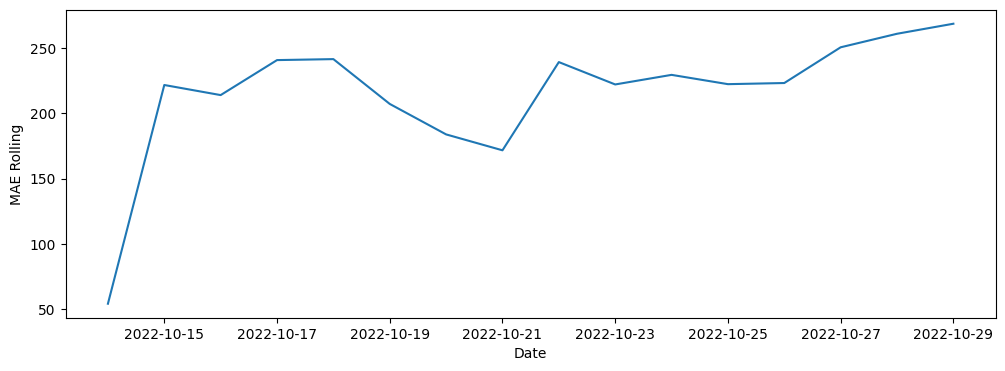

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(prediction_forecast['ds'], prediction_forecast['mae_rolling'])
plt.xlabel('Date')
plt.ylabel('MAE Rolling')
plt.show()

In [60]:
#MAE
from sklearn.metrics import mean_absolute_error

y_true = prediction_forecast["y_true"]
y_pred = prediction_forecast["yhat"]

mae = mean_absolute_error(y_true, y_pred)

mae

203.85201639044806

### Plotting Time Series effects

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly


plot_components_plotly(m, forecast)

### Analyzing regressor coefficients

In [61]:
from prophet.utilities import regressor_coefficients

coefficients = regressor_coefficients(m)
coefficients

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temp,additive,17.305988,25.678594,25.678594,25.678594
1,wind_speed,additive,5.313592,-10.864555,-10.864555,-10.864555
2,wind_deg,additive,202.138739,-0.051878,-0.051878,-0.051878
3,rain,additive,0.092132,-47.795809,-47.795809,-47.795809
4,clouds,additive,33.001201,-1.098048,-1.098048,-1.098048
5,Holiday,multiplicative,0.000000,0.139585,0.139585,0.139585
6,inflation_rate,multiplicative,2.501502,0.097412,0.097412,0.097412


### Saving prediction as csv

In [ ]:
#prediction_forecast.to_csv("output_data/baseline_prediction.csv")